In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# These are for testing
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
def get_data(path):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    df = pd.read_csv(path)
    return(df)

In [3]:
def train_test_split(df, train_percent=0.666666):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    np.random.seed(4109)
    df = df.sample(frac=1).reset_index(drop=True)
    
    n_train = round(train_percent*len(df))
    df_train = df[:n_train]
    df_test = df[n_train:]
    
    return(df_train, df_test)

In [4]:
def get_grid_search_vals(start_g, stop_g, start_s, stop_s):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    gamma_powers = np.arange(start_g, stop_g + 1, 1)
    sigma_powers = np.arange(start_s, stop_s + 1, 0.5)
    
    gamma = np.power(0.5, gamma_powers)
    sigma = np.power(2, sigma_powers)
    
    return(gamma, sigma)

In [5]:
def get_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    https://stackoverflow.com/questions/42991347/how-to-find-the-pairwise-differences-between-rows-of-two-very-large-matrices-usi
    -------------------------
    '''
    # Element wise product and then sum horizontally
    # Element wise product and then sum horizontally
    # Dot product between A and B.T
    dist = np.einsum('ij,ij->i',A, A)[:,None] + np.einsum('ij,ij->i',B,B) - 2*np.dot(A,B.T)
    return(dist)

In [6]:
def test_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    https://stackoverflow.com/questions/45896939/using-python-numpy-einsum-to-obtain-dot-product-between-2-matrices
    -------------------------
    '''
    dist = get_pairwise_dist(A, B)
    dist_sk = cdist(A, B)**2
    return(dist, dist_sk, np.allclose(dist, dist_sk))

In [7]:
def get_gaussian_kernel(X, X_test, sigma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    scale = -0.5/np.power(sigma, 2)
    K = get_pairwise_dist(X, X_test) 
    K = K*scale
    K = np.exp(K)
    return(K)

In [8]:
def get_kernel_ridge_coeff(X, Y, sigma, gamma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    m = Y.shape[0]
    K = get_gaussian_kernel(X, X, sigma)
    
    alpha = np.linalg.solve(K + gamma*np.identity(m), Y)
    alpha = alpha.reshape(alpha.shape[0], 1)
    
    return(alpha)

In [9]:
def get_kernel_ridge_prediction(alpha, X, X_test, sigma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    K_test = get_gaussian_kernel(X, X_test, sigma)
    # Multiply element wise and then sum downwards to get # test points columns
    y_pred = np.einsum('ij,ij->j', alpha, K_test)
    return(y_pred)

In [10]:
def get_k_folds(df_train, k = 5):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Set the seed to make sure reproducible
    # Then create a list of folds
    np.random.seed(43890)
    fold_size = round(len(df_train)/k)
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_folds = [df_train.iloc[i:i+fold_size] for i in range(0,len(df_train)-fold_size+1,fold_size)]
    return(df_folds)

In [11]:
def get_mse(Y, Y_hat):
    '''
    ------------------------
    Input: True values and predicted values
    Output: Mean squared error
    ------------------------
    '''
    return np.sum(np.power(Y-Y_hat, 2))/max(Y.shape)

In [12]:
def plot_3d_mse(history, 
                k=5, 
                path = os.path.join('.', '..', 'figs', '1_3_cv_error.png'),
                title = 'Cross Validation Error by Parameter Settings'):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Store the data
    x = np.array(history['gamma'])
    y = np.array(history['sigma'])
    z = np.array(history['mse_val'])
    
    # Make the plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Make the plot
    ax.scatter3D(x, y, z, c=z, cmap='jet_r');
    ax.set_title(title)
    
    # Set labels
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\sigma$')
    ax.set_zlabel(r'Mean MSE over {} folds$'.format(k))
    
    # Save and then display
    plt.savefig(path)
    plt.show()

In [13]:
def train_kernel_ridge(X_train, X_val, Y_train, Y_val, sigma, gamma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Get dual form estimates
    alpha = get_kernel_ridge_coeff(X_train, Y_train, sigma, gamma)

    # Get predictions
    y_pred_train = get_kernel_ridge_prediction(alpha, X_train, X_train, sigma)
    y_pred_val = get_kernel_ridge_prediction(alpha, X_train, X_val, sigma)
    
    # Get loss values
    mse_train = get_mse(Y_train, y_pred_train)
    mse_val = get_mse(Y_val, y_pred_val)
    
    return(alpha, y_pred_train, y_pred_val, mse_train, mse_val)

In [14]:
def get_best_params(history):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    best_run = np.array(history['mse_val']).argmin()
    best_val_mse = np.array(history['mse_val']).min()
    
    best_gamma, best_sigma = history['gamma'][best_run], history['sigma'][best_run]
    best_alpha = history['alpha'][best_run]
    
    best_params = {'best_run': best_run, 
                   'best_gamma': best_gamma, 
                   'best_sigma': best_sigma, 
                   'best_val_mse': best_val_mse, 
                   'best_run_alpha': best_alpha}
    
    return(best_params)

In [15]:
def test_gaussian_kernel(X, X_test, sigma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    kernel = get_gaussian_kernel(X, X_test, sigma)
    kernel_sk = rbf_kernel(X, X_test, 0.5)
    return(np.allclose(kernel, kernel_sk))

def test_kernel_ridge_coeff():
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4]).reshape(2,1)
    result = get_kernel_ridge_coeff(K, b, 1, 2)
    return(result)

def test_kernel_ridge_prediction():
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([5, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 25, 26, 7, 8]).reshape(4,4)
    
    alpha = test_kernel_ridge_coeff()
    result = get_kernel_ridge_prediction(alpha, a, b, 1)
    
    return(result)


def tests():
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Make test data
    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4, 6, 8, 10, 12, 14, 16]).reshape(2,4)
    
    dist_test_result = test_pairwise_dist(a, b)
    kern_test_result = test_gaussian_kernel(a, b, 1)
    
    coeff_test_result = test_kernel_ridge_coeff()
    prediction_test_result = test_kernel_ridge_prediction()
    
    return(dist_test_result, kern_test_result)

In [16]:
def main(k=5):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Setup
    path = 'http://www0.cs.ucl.ac.uk/staff/M.Herbster/boston-filter/Boston-filtered.csv'
    
    # Set parameters for grid search
    start_g = 26
    stop_g = 40
    start_s = 7
    stop_s = 13
    
    # Get list of parameters to search over
    gamma_list, sigma_list = get_grid_search_vals(start_g, stop_g, start_s, stop_s)
    
    # Load data
    df = get_data(path)
    
    # Split into train and test: we are making 2/3 splits as required by default
    df_train, df_test = train_test_split(df)

    # Divide training data into k=5 folds for cross-validation as question asks
    df_folds = get_k_folds(df_train, k)
    
    # Convert data-frames into numpy arrays
    X_folds = [df_fold.iloc[:,:12].to_numpy() for df_fold in df_folds]
    Y_folds = [df_fold['MEDV'].to_numpy() for df_fold in df_folds]
    
    # Create a container to store results
    history = {'gamma': [],
               'sigma': [],
               'mse_val': [],
               'mse_train': [], 
               'pred_train': [],
               'pred_val': [],
               'alpha': []}
    
    counter = 0
    
    # This loop iterates over the grid
    for sigma in sigma_list:
        for gamma in gamma_list:
            
            # Record the parameter values
            history['sigma'].append(sigma)
            history['gamma'].append(gamma)
            
            # Print progress check
            counter += 1
            print(counter)
            
            # Make containers for train and validation MSE by fold
            mse_train_by_fold = []
            mse_val_by_fold = []
    
            # Now train for each fold
            for i in range(k):
        
                # Stack data matrices
                X_train_fold = np.vstack(X_folds[0:i] + X_folds[i+1:])
                Y_train_fold = np.hstack(Y_folds[0:i] + Y_folds[i+1:])
            
                # Get the ith fold and take it as the validation labels
                # The rest of the data are stacked and put in a container
                X_val_fold = X_folds[i]
                Y_val_fold = Y_folds[i]
        
                # Train the ridge regression
                alpha, y_pred_train, y_pred_val, mse_train, mse_val = train_kernel_ridge(X_train_fold, 
                                                                                         X_val_fold, Y_train_fold, 
                                                                                         Y_val_fold, sigma, gamma)
                
                # Store the result
                mse_train_by_fold.append(mse_train)
                mse_val_by_fold.append(mse_val)
                
            print(mse_train_by_fold)
            print(mse_val_by_fold)
            
            history['alpha'].append(alpha)
            history['pred_train'].append(y_pred_train)
            history['pred_val'].append(y_pred_val)
            history['mse_val'].append(np.mean(np.array(mse_val_by_fold)))
            history['mse_train'].append(np.mean(np.array(mse_train_by_fold)))
    
    # Store best parameters
    best_params = get_best_params(history)
    
    # Make plot
    plot_3d_mse(history)
      
    return(history, best_params)

1
[1.8535968822903233, 1.6303227795412492, 2.1388021699113597, 1.0349575087698328, 0.8099556923539831]
[80.26527998517186, 76.55638247771057, 92.95038176511945, 1108.279507406872, 56.23824914102332]
2
[1.5082135194441095, 1.384516618904326, 1.8590008757859133, 0.7992857761674441, 0.5655072295506672]
[107.30219881505333, 130.9475814878212, 115.33029722765559, 1272.4672768434932, 74.02767066101748]
3
[1.17582978425696, 1.1618064420368959, 1.5703609685754047, 0.6049350011306889, 0.3834483523761911]
[138.35052639741727, 216.7712003414733, 131.75282468494507, 1413.5364157231522, 97.17737946720888]
4
[0.8881335050060276, 0.9746376251407273, 1.2933476649069127, 0.4400568911462018, 0.2627526970701295]
[164.336980991176, 313.0083902776635, 137.5090773060237, 1628.7910090361806, 118.48116200489143]
5
[0.6566110726231943, 0.8186817226028613, 1.0445586122149886, 0.309752610206579, 0.18469846494336886]
[176.16743078187693, 406.6046325683571, 141.7368349320478, 1970.573705841049, 130.4089796558107]


[4.357982787131642, 3.7414016824134047, 4.51013020658611, 3.686056798490848, 2.9255873064423783]
[17.332388419236576, 23.482413969174708, 6.318284077495338, 17.09542816434599, 17.850155585424584]
48
[3.902337325171633, 3.3098819388000176, 4.0606305360379435, 3.286654903073754, 2.540212709832393]
[21.252928334644718, 30.883541819208308, 6.60340425282528, 18.290613977406807, 20.053742642982865]
49
[3.508747436194648, 2.9662797056025934, 3.685505819085952, 2.901848095225467, 2.2189920945669055]
[25.0933315235675, 40.99429497087382, 7.258079906043303, 21.878868689646197, 23.220449045760898]
50
[3.1705957409662453, 2.70045429281357, 3.36950376911534, 2.51672791529735, 1.9310110058000571]
[28.428379024041398, 53.35078970692898, 9.984633782301103, 28.392401511919058, 27.26906973535601]
51
[2.872666111449388, 2.4902905702484524, 3.0920533700219455, 2.141824503921674, 1.6459783667891426]
[30.724559471699248, 68.33425753425949, 17.47373903525802, 39.281150108461134, 32.57878174125678]
52
[2.5893

[7.7601179798320485, 6.534216431871941, 7.521997796998973, 6.655074746942292, 6.232307321073564]
[7.6403881773331115, 15.174728245194357, 10.24173080861785, 15.52172820992391, 13.654206333481856]
94
[7.343076297851862, 6.225740416996529, 7.185736151097521, 6.261817638473163, 5.785054215532314]
[7.46241703985517, 15.074416282437426, 9.440983399775698, 16.231266448265618, 13.759092490161981]
95
[6.921377946521035, 5.915521673676832, 6.828451010908189, 5.878951354390073, 5.343327479777674]
[7.424665634245629, 14.870990719698998, 8.540505003547958, 17.005020061802735, 13.985661272063158]
96
[6.501628278259482, 5.583991627910336, 6.440024186853328, 5.5060689744681, 4.90600700873615]
[7.5195402174273624, 14.736263163779435, 7.7509233526887344, 17.848128367653313, 14.288923275231078]
97
[6.066820978123452, 5.212323937742271, 6.009761244924101, 5.127887893178372, 4.460416483934037]
[7.667669061122975, 15.013024217148741, 7.227025015069071, 18.810547374352637, 14.647097082681727]
98
[5.59537094

[10.863795444897908, 9.777959947258475, 10.769993686546123, 10.242702099111487, 9.703698828729383]
[10.471126077195969, 16.360572338925802, 10.14598841188689, 13.934427043829686, 17.120110689731785]
139
[10.276125152355034, 9.153291896981164, 10.06325179803109, 9.657663829794997, 9.07304896159521]
[10.246155499807378, 15.75248734054641, 10.37671292077234, 13.272413857146764, 15.796953171884752]
140
[9.850362448638117, 8.666084395381652, 9.5165463223549, 9.207154327636562, 8.565973137573302]
[9.879408978933702, 15.47880534489861, 11.126228798438541, 12.791648587071741, 15.04544649001267]
141
[9.471228492315117, 8.221639009416377, 9.057512196886425, 8.800595644972812, 8.130954345447282]
[9.415484187207202, 15.401491901191749, 12.026517014590652, 12.52063000943956, 14.6216521862035]
142
[9.094777620722178, 7.791476858273235, 8.6573353019678, 8.388344791555356, 7.735151971282657]
[9.015817553093026, 15.508210517602093, 12.806110514920903, 12.503976134814232, 14.340616776453297]
143
[8.7188

[8.251217077329978, 7.008640439910676, 7.891564275053009, 7.401108510627675, 6.8322773760824065]
[8.914046841130327, 16.79990421184853, 14.249762470606552, 13.316973109458809, 14.15754270183506]
180
[7.882673744692731, 6.713599213770967, 7.593012093270003, 6.958660009761355, 6.430323036393124]
[8.989712897770438, 17.04640617697986, 13.840568574471261, 14.198407691699357, 14.218171868964808]
181
[25.47424844519848, 21.245270080222163, 24.53621276553079, 22.845205327300366, 20.803377513322946]
[16.148626118948272, 34.3352204988428, 20.74863521208911, 31.337634195933312, 36.55489164751842]
182
[24.260863141715447, 20.19869551756396, 23.415925846849582, 21.871530061301023, 19.858469136216232]
[15.520327944337929, 33.391196972224485, 19.76042764716181, 30.10578384182799, 35.75907492899717]
183
[22.655836949564875, 18.971498120576435, 21.924713595367532, 20.59572213067273, 18.67370788146447]
[14.764455266696139, 31.959708726300892, 18.571854385078527, 28.3572847389918, 34.2811662219925]
184


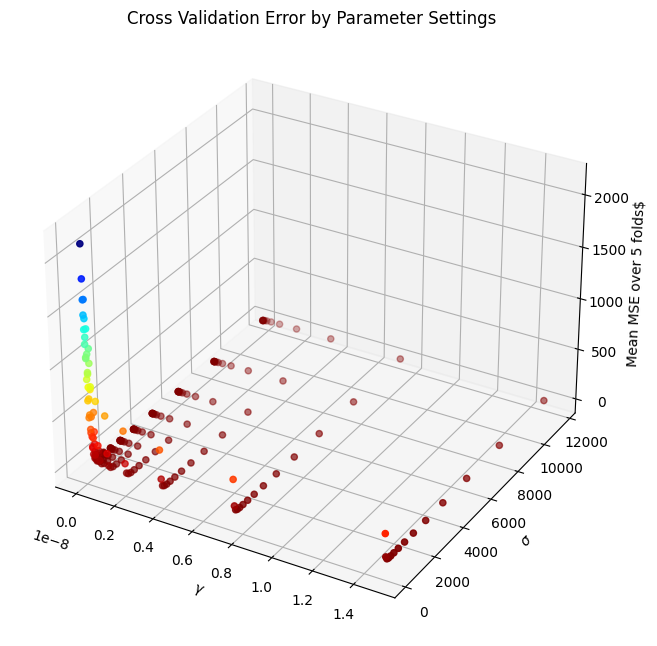

In [17]:
history, best_params = main()